# Optimizing the Text Generation Model

By using more data and further tweaking the model, we'll be able to get improved results. We'll once again use the [Kaggle Song Lyrics Dataset](https://www.kaggle.com/mousehead/songlyrics) here.

## Import TensorFlow and related functions

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Other imports for processing data
import string
import numpy as np
import pandas as pd

## Get the Dataset

As noted above, we'll utilize the [Song Lyrics dataset](https://www.kaggle.com/mousehead/songlyrics) on Kaggle again.

In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 \
    -O /tmp/songdata.csv

--2022-07-05 12:20:27--  https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.google.com (drive.google.com)... 172.253.63.113, 172.253.63.138, 172.253.63.102, ...
Connecting to drive.google.com (drive.google.com)|172.253.63.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1hs2nitq70ap7mc11u1m5up3t655hejl/1657023600000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8?uuid=642308f7-3e5b-4332-bca8-a20431ca0a10 [following]
--2022-07-05 12:20:30--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1hs2nitq70ap7mc11u1m5up3t655hejl/1657023600000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8?uuid=642308f7-3e5b-4332-bca8-a20431ca0a10
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 172.253.62.132, 2607:f8b0:4004:c07::84
Connecting to doc-04

## 250 Songs

Now we've seen a model trained on just a small sample of songs, and how this often leads to repetition as we get further along in trying to generate new text. Let's switch to using the 250 songs instead, and see if our output improves. This will actually be nearly 10K lines of lyrics, which should be sufficient.

Note that we won't use the full dataset here as it will take up quite a bit of RAM and processing time, but you're welcome to try doing so on your own later. If interested, we'll likely want to use only some of the more common words for the Tokenizer, which will help shrink processing time and memory needed (or else we'd have an output array hundreds of thousands of words long).

### Preprocessing

In [3]:
def tokenize_corpus(corpus, num_words=-1):
  # Fit a Tokenizer on the corpus
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

def create_lyrics_corpus(dataset, field):
  # Remove all other punctuation
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
  # Make it lowercase
  dataset[field] = dataset[field].str.lower()
  # Make it one long string to split by line
  lyrics = dataset[field].str.cat()
  corpus = lyrics.split('\n')
  # Remove any trailing whitespace
  for l in range(len(corpus)):
    corpus[l] = corpus[l].rstrip()
  # Remove any empty lines
  corpus = [l for l in corpus if l != '']

  return corpus

In [4]:
def tokenize_corpus(corpus, num_words=-1):
  # Fit a Tokenizer on the corpus
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

# Read the dataset from csv - this time with 250 songs
dataset = pd.read_csv('/tmp/songdata.csv', dtype=str)[:250]
# Create the corpus using the 'text' column containing lyrics
corpus = create_lyrics_corpus(dataset, 'text')
# Tokenize the corpus
tokenizer = tokenize_corpus(corpus, num_words=2000)
total_words = tokenizer.num_words

# There should be a lot more words now
print(total_words)

2000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  if sys.path[0] == '':


### Create Sequences and Labels

In [5]:
sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		sequences.append(n_gram_sequence)

# Pad sequences for equal input length 
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))

# Split sequences between the "input" sequence and "output" predicted word
input_sequences, labels = sequences[:,:-1], sequences[:,-1]
# One-hot encode the labels
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

### Train a (Better) Text Generation Model

With more data, we'll cut off after 100 epochs to avoid keeping you here all day. We'll also want to change your runtime type to GPU if you haven't already (we'll need to re-run the above cells if you change runtimes).

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#history = model.fit(input_sequences, one_hot_labels, epochs=100, verbose=1)
history = model.fit(input_sequences, one_hot_labels, epochs=10, verbose=1)

Epoch 1/10
1480/1480 [==============================] - 16s 9ms/step - loss: 5.9795 - accuracy: 0.0468
Epoch 2/10
1480/1480 [==============================] - 12s 8ms/step - loss: 5.6791 - accuracy: 0.0506
Epoch 3/10
1480/1480 [==============================] - 11s 8ms/step - loss: 5.4646 - accuracy: 0.0679
Epoch 4/10
1480/1480 [==============================] - 11s 8ms/step - loss: 5.3099 - accuracy: 0.0878
Epoch 5/10
1480/1480 [==============================] - 11s 8ms/step - loss: 5.1747 - accuracy: 0.1047
Epoch 6/10
1480/1480 [==============================] - 11s 8ms/step - loss: 5.0344 - accuracy: 0.1218
Epoch 7/10
1480/1480 [==============================] - 11s 8ms/step - loss: 4.9082 - accuracy: 0.1378
Epoch 8/10
1480/1480 [==============================] - 11s 8ms/step - loss: 4.7790 - accuracy: 0.1527
Epoch 9/10
1480/1480 [==============================] - 11s 8ms/step - loss: 4.6512 - accuracy: 0.1647
Epoch 10/10
1480/1480 [==============================] - 11s 8ms/step - l

### View the Training Graph

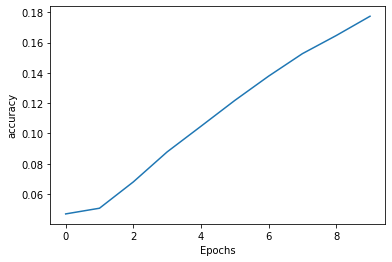

In [8]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

### Generate better lyrics!

This time around, we should be able to get a more interesting output with less repetition.

In [9]:
seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

im feeling chills me to the way you do it to the way you do it to the way you do it to me you know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i know i


### Varying the Possible Outputs

In running the above, we may notice that the same seed text will generate similar outputs. This is because the code is currently always choosing the top predicted class as the next word. What if you wanted more variance in the output? 

Switching from `model.predict_classes` to `model.predict_proba` will get us all of the class probabilities. We can combine this with `np.random.choice` to select a given predicted output based on a probability, thereby giving a bit more randomness to our outputs.

In [10]:
# Test the method with just the first word after the seed text
seed_text = "im feeling chills"
next_words = 100
  
token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
predicted_probs = model.predict(token_list)[0]
predicted = np.random.choice([x for x in range(len(predicted_probs))], 
                             p=predicted_probs)
# Running this cell multiple times should get you some variance in output
print(predicted)

13


In [11]:
# Use this process for the full output generation
seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  predicted_probs = model.predict(token_list)[0]
  predicted = np.random.choice([x for x in range(len(predicted_probs))],
                               p=predicted_probs)
  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

im feeling chills me for you i have nothing to can so i guess that alone to that bloody hour you daddys helen flown way fly to stay alone pass out the wind by everyone parted rough pretty star two be long city glow those a searching old turmoil impossible somewhere anything up the feeling a dancing back aint to your chill soon that beats their eyes itself not theyre no lost to small honey honey but she still lose the girls go down down upon the man for of his nah tone is a stream to get so now weve dont are
